In [74]:
import pandas as pd
import numpy as np

### 6.5 Lab 1: Subset Selection Methods
#### 6.5.1 Best Subset Selection
Here we apply the best subset selection approach to the Hitters data. We
wish to predict a baseball player’s Salary on the basis of various statistics
associated with performance in the previous year.
First of all, we note that the Salary variable is missing for some of the players.

In [75]:
# Load dataset
# We later want to fit using horsepower, so remove its rows with NA
hitters = pd.read_csv('Data/Hitters.csv', index_col = 0)
display(f"Missing data in {hitters.columns[hitters.isna().any()].tolist()}")
num_missing = np.sum(hitters.Salary.isnull())
print('We are missing Salary data for', num_missing, 'players.')
# Drop these players
hitters = hitters.dropna()
display(hitters.describe(include = "O"))
display(hitters.describe(include = [np.number]))

"Missing data in ['Salary']"

We are missing Salary data for 59 players.


,League,Division,NewLeague
count,263,263,263
unique,2,2,2
top,A,W,A
freq,139,134,141


,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary
count,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000,263.000000
mean,403.642586,107.828897,11.619772,54.745247,51.486692,41.114068,7.311787,2657.543726,722.186312,69.239544,361.220532,330.418251,260.266160,290.711027,118.760456,8.593156,535.925882
std,147.307209,45.125326,8.757108,25.539816,25.882714,21.718056,4.793616,2286.582929,648.199644,82.197581,331.198571,323.367668,264.055868,279.934575,145.080577,6.606574,451.118681
min,19.000000,1.000000,0.000000,0.000000,0.000000,0.000000,1.000000,19.000000,4.000000,0.000000,2.000000,3.000000,1.000000,0.000000,0.000000,0.000000,67.500000
25%,282.500000,71.500000,5.000000,33.500000,30.000000,23.000000,4.000000,842.500000,212.000000,15.000000,105.500000,95.000000,71.000000,113.500000,8.000000,3.000000,190.000000
50%,413.000000,103.000000,9.000000,52.000000,47.000000,37.000000,6.000000,1931.000000,516.000000,40.000000,250.000000,230.000000,174.000000,224.000000,45.000000,7.000000,425.000000
75%,526.000000,141.500000,18.000000,73.000000,71.000000,57.000000,10.000000,3890.500000,1054.000000,92.500000,497.500000,424.500000,328.500000,322.500000,192.000000,13.000000,750.000000
max,687.000000,238.000000,40.000000,130.000000,121.000000,105.000000,24.000000,14053.000000,4256.000000,548.000000,2165.000000,1659.000000,1566.000000,1377.000000,492.000000,32.000000,2460.000000


Python doesn't have best subset selection so we need to write our own.
We first encode categorical variables. Each categorical features have two levels, so we leave one binary for each, to avoid collinearity.
We will be evauting our model results based on RSS score.

In [76]:
dummies = pd.get_dummies(hitters[['League', 'Division', 'NewLeague']], drop_first=True)
display(dummies.head())

hitters.drop(labels=['League', 'Division', 'NewLeague'], axis="columns", inplace=True)
hitters[['League', 'Division', 'NewLeague']] = dummies

hitters.head()

,League_N,Division_W,NewLeague_N
-Alan Ashby,1,1,1
-Alvin Davis,0,1,0
-Andre Dawson,1,0,1
-Andres Galarraga,1,0,1
-Alfredo Griffin,0,1,0


,AtBat,Hits,HmRun,Runs,RBI,Walks,Years,CAtBat,CHits,CHmRun,CRuns,CRBI,CWalks,PutOuts,Assists,Errors,Salary,League,Division,NewLeague
-Alan Ashby,315,81,7,24,38,39,14,3449,835,69,321,414,375,632,43,10,475.0,1,1,1
-Alvin Davis,479,130,18,66,72,76,3,1624,457,63,224,266,263,880,82,14,480.0,0,1,0
-Andre Dawson,496,141,20,65,78,37,11,5628,1575,225,828,838,354,200,11,3,500.0,1,0,1
-Andres Galarraga,321,87,10,39,42,30,2,396,101,12,48,46,33,805,40,4,91.5,1,0,1
-Alfredo Griffin,594,169,4,74,51,35,11,4408,1133,19,501,336,194,282,421,25,750.0,0,1,0


In [77]:
from itertools import combinations
import statsmodels.api as sm

def best_subset_for_size(size, dataframe, response):
    """
    Returns the best odel from all models with k-predictors (lowest RSS).
    """
    results = {}
    features = dataframe.drop(response, axis = 1).columns
    subsets = list(combinations(features, size))
    for subset in subsets:
        subset = list(subset)
        score, model = calculate_model(subset, response, dataframe)
        if score in results.keys():
            results[score].append(model)
        else:
            results[score] = [model] 

    return results[min(results.keys())]

def calculate_model(subset, response, dataframe):
    """
    Constructs Linear Model Regression of response onto feature and calculates RSSs.
    """
    X = sm.add_constant(dataframe[subset])
    y = dataframe[response]

    model = sm.OLS(y,X).fit()
    score = model.ssr
    return score, model

def best_subset_selection(dataframe, response):
    """
    Does best subset selection.
    """
    best_dict = {}
    #for size in range(1,8):
    for size in range(1,dataframe.shape[1]):
        result = best_subset_for_size(size, dataframe, response)
        best_dict[size] = result

    return best_dict

best_dict = best_subset_selection(dataframe = hitters, response ="Salary")


We only calculate the first 7 sizes, as it takes a lot of computing time for higher numbers.

We now build a dataframe with our model results:

In [78]:
models = list(best_dict.values())
display(models)
aics = [model.aic for [model] in models]
bics = [model.bic for [model] in models]
r_adj = [model.rsquared_adj for [model] in models]
features = [model.model.exog_names for [model] in models]
r_squared = [model.rsquared for [model] in models]

data = {
    "features": features,
    "rsquared": r_squared,
    "aic": aics,
    "bic": bics,
    "r_adj": r_adj,
}
best_subset_results = pd.DataFrame(data)
display(best_subset_results)

[[<statsmodels.regression.linear_model.RegressionResultsWrapper at 0x7fe926ccbd90>],

,features,rsquared,aic,bic,r_adj
0,"[const, CRBI]",0.321450,3862.139307,3869.283615,0.318850
1,"[const, Hits, CRBI]",0.425224,3820.487305,3831.203767,0.420802
2,"[const, Hits, CRBI, PutOuts]",0.451429,3810.214440,3824.503056,0.445075
3,"[const, Hits, CRBI, PutOuts, Division]",0.475407,3800.460294,3818.321064,0.467273
4,"[const, AtBat, Hits, CRBI, PutOuts, Division]",0.490804,3794.625624,3816.058548,0.480897
5,"[const, AtBat, Hits, Walks, CRBI, PutOuts, Div...",0.508715,3787.208000,3812.213078,0.497200
6,"[const, Hits, Walks, CAtBat, CHits, CHmRun, Pu...",0.514123,3786.296813,3814.874046,0.500785
7,"[const, AtBat, Hits, Walks, CHmRun, CRuns, CWa...",0.528557,3780.365349,3812.514735,0.513708
8,"[const, AtBat, Hits, Walks, CAtBat, CRuns, CRB...",0.534612,3778.965286,3814.686826,0.518057
9,"[const, AtBat, Hits, Walks, CAtBat, CRuns, CRB...",0.540495,3777.619775,3816.913469,0.522261


For instance, we see that the R2 statistic increases from 32 %, when only
one variable is included in the model, to almost 55 %, when all variables
are included. As expected, the R2 statistic increases monotonically as more
variables are included.

Plotting RSS, adjusted R2, Cp, and BIC for all of the models at once will
help us decide which model to select. 

Here we only plot BIC, and observe the model with 6 variables has the lowest from the calculated sizes.

<AxesSubplot:xlabel='size'>

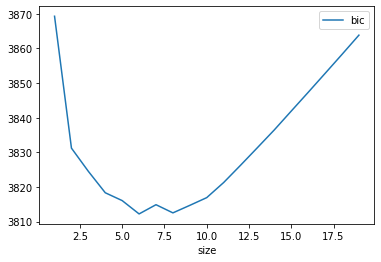

In [79]:
import matplotlib.pyplot as plt
best_subset_results["size"] = list(range(1,20))
best_subset_results.plot(x="size" , y="bic")

Params for model size 6 is:


In [80]:
models[5][0].params

const        91.511798
AtBat        -1.868589
Hits          7.604398
Walks         3.697647
CRBI          0.643017
PutOuts       0.264308
Division   -122.951534
dtype: float64

### 6.5.2 Forward and Backward Stepwise Selection

We will use sklear's sequential feaure selection.

In [81]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
X = hitters.drop(columns="Salary", axis = 1)
Y = hitters.Salary
linreg = LinearRegression(normalize = "True")
selected = pd.DataFrame(index = X.columns)
for size in range(1,19):
    # turning off cv included by default to reproduce ISLR results
    sfs = SequentialFeatureSelector(linreg, direction = "forward", n_features_to_select=size, cv=[(slice(None), slice(None))])
    sfs.fit(X, Y)
    selected[size]=sfs.get_support().astype(int)
display("Forward:")
display(selected)

'Forward:'

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
AtBat,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Hits,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
HmRun,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1
Runs,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1
RBI,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1
Walks,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1
Years,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
CAtBat,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1
CHits,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1
CHmRun,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


In [82]:
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.linear_model import LinearRegression
X = hitters.drop(columns="Salary", axis = 1)
Y = hitters.Salary
linreg = LinearRegression(normalize = "True")
selected = pd.DataFrame(index = X.columns)
for size in range(1,19):
    # turning off cv included by default to reproduce ISLR results
    sfs = SequentialFeatureSelector(linreg, direction = "backward", n_features_to_select=size, cv=[(slice(None), slice(None))])
    sfs.fit(X, Y)
    selected[size]=sfs.get_support().astype(int)
display("Backward:")
display(selected)

'Backward:'

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
AtBat,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Hits,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
HmRun,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1
Runs,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1
RBI,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1
Walks,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Years,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
CAtBat,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1
CHits,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1
CHmRun,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0


For instance, we see that using forward stepwise selection, the best onevariable model contains only CRBI, and the best two-variable model additionally includes Hits. For this data, the best one-variable through sixvariable models are each identical for best subset and forward selection.
However, the best seven-variable models identified by forward stepwise selection, backward stepwise selection, and best subset selection are different.

### 6.5.3 Choosing Among Models Using the Validation Set Approach and Cross-Validation
We just saw that it is possible to choose among a set of models of different
sizes using Cp, BIC, and adjusted R2. We will now consider how to do this
using the validation set and cross-validation approaches.
In order for these approaches to yield accurate estimates of the test
error, we must use only the training observations to perform all aspects of
model-fitting—including variable selection. Therefore, the determination of
which model of a given size is best must be made using only the training
observations. This point is subtle but important. If the full data set is used
to perform the best subset selection step, the validation set errors and
cross-validation errors that we obtain will not be accurate estimates of the
test error.

In order to use the validation set approach, we begin by splitting the observations into a training set and a test set. Then we fit the model on the training set, and compute the prediction errors on the validation set.

We won't fit higher than 7 varibles as it takes long, but 10 variables should yield the best result according to the book.

In [83]:
# Using our previous statsmodel OLS best subset selection function
np.random.seed(0)
train_set = hitters.sample(frac=0.5)
test_set = hitters.drop(train_set.index)

best_dict = best_subset_selection(dataframe = train_set, response ="Salary")






MSEs = [125311.28387076 139560.47322038 124696.98658086 120728.68437386
 115831.0998919  113935.06237767 113074.64358822 115698.0470094
 116313.89794115 109351.69922015 109783.11985163 112843.34793339
 115360.9559786  117204.63336066 118293.1202643  118787.23336239
 118560.36570098 118331.37004955 118280.11626815]


Text(0.5, 0, 'size')

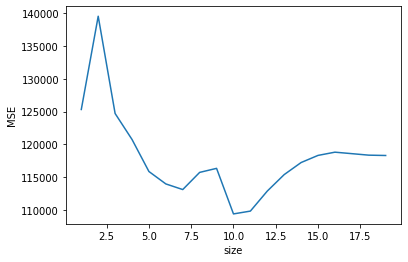

In [84]:

mses = np.array([])
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt
for [model] in best_dict.values():
    features = list(model.params.index[1:])
    X_test = sm.add_constant(test_set[features])
    predictions = model.predict(X_test)
    mse = mean_squared_error(test_set.Salary, predictions)
    mses = np.append(mses,mse)
print('MSEs =', mses)

size = list(range(1,20))
plt.plot(size , mses)

plt.ylabel('MSE')
plt.xlabel('size')

Finally, we should perform best subset selection on the full data set, and select
the best ten-variable model. It is important that we make use of the full
data set in order to obtain more accurate coefficient estimates. Note that
we perform best subset selection on the full data set and select the best tenvariable model, rather than simply using the variables that were obtained
from the training set, because the best ten-variable model on the full data
set may differ from the corresponding model on the training set.

We now try to choose among the models of different sizes using crossvalidation. While the original lab used best subset selection, I will be using forward subset selection, as best subset selection takes very long and is inefficient.

My approach will be different from the lab. The lab does best subset selection for each of the folds, meaning tests all the number of features for each fold, and choses the smallest cross-validated error.
So the lab first decides on the number of features with cross-validation, and then does best subset selection on the full dataset to obtain the best model with the determined number of features.

I will be running a cross-validated feature selection for each size separately, selecting the best m  features for each m. Then, I fit a cross-validated Linear regression on these 19 models to chose the best one. So I will not be choosing the number of features first, and then the features, but instead the best k features for each k, and then k.



In [86]:
X = hitters.drop(columns="Salary", axis = 1)
Y = hitters.Salary
linreg = LinearRegression(normalize = "True")
selected = pd.DataFrame(index = X.columns)
best_size = 0
for size in range(1,19):
    sfs = SequentialFeatureSelector(linreg, scoring = "neg_mean_squared_error", direction = "forward", n_features_to_select=size, cv=10)
    sfs.fit(X, Y)
    selected[size]=sfs.get_support().astype(int)
display("Forward:")
display(selected)

'Forward:'

,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
AtBat,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1
Hits,0,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1,1
HmRun,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1,1,1
Runs,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1,1
RBI,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1
Walks,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1,1
Years,0,0,0,0,0,0,1,1,1,1,1,1,1,1,1,1,1,1
CAtBat,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,1
CHits,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1
CHmRun,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1


In [123]:
from sklearn.model_selection import cross_val_score

X = hitters.drop(columns="Salary", axis = 1)
Y = hitters.Salary
scores = []
linreg = LinearRegression(normalize = "True")
for size in range(1,20):
    if size < 19:
        mask = selected[size].astype(bool)
        score = np.mean(cross_val_score(linreg, X.loc[:,mask], Y, cv=10, scoring = "neg_mean_squared_error"))
        scores.append(score)
    if size == 19:
        score = np.mean(cross_val_score(linreg, X, Y, cv=10, scoring = "neg_mean_squared_error"))
        scores.append(score)
display(scores)

display(f"The best model is that with {scores.index(max(scores))+1} features according to our method." )


[-142840.888022004,
 -124466.24099202009,
 -119615.54726015376,
 -114839.7062808496,
 -112424.87165671433,
 -108549.67515036926,
 -108803.72236793858,
 -108860.38493982807,
 -106654.37407806476,
 -107211.09802323833,
 -107680.64431442802,
 -108310.97513209368,
 -108987.01494667128,
 -109812.67389905857,
 -110463.634702026,
 -111421.81553973742,
 -112986.92792146467,
 -114637.21027506089,
 -116599.01367380252]

'The best model is that with 9 features according to our method.'